In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff



t_end = 20
t1   =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0, t_end, 100)
eps = 0.01
T_slow_end = 1
tau1 = np.linspace(0, T_slow_end, 100)
tau2 = np.linspace(0, T_slow_end, 100)
tau3 = np.linspace(0, T_slow_end, 100)

tau1_tensor = torch.tensor(tau1.reshape(-1, 1), dtype=torch.float64)
t1_tensor = torch.tensor(t1.reshape(-1, 1), dtype=torch.float64) 
tau2_tensor = torch.tensor(tau2.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)
tau3_tensor = torch.tensor(tau3.reshape(-1, 1), dtype=torch.float64)


def input_transform(tau1_tensor):
    return torch.cat([tau1_tensor], dim=1)

num_nrn = 7

class slow_system_PINN1(nn.Module):
    def __init__(self):
        super(slow_system_PINN1, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau1):
        x = F.tanh(self.fc1(tau1))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class fast_system_PINN1(nn.Module):
    def __init__(self):
        super(fast_system_PINN1, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t1):
        x = F.tanh(self.fc1(t1))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN2(nn.Module):
    def __init__(self):
        super(slow_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau2):
        x = F.tanh(self.fc1(tau2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
      
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN3(nn.Module):
    def __init__(self):
        super(slow_system_PINN3, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau3):
        x = F.tanh(self.fc1(tau3))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [2]:
z1, z2 = 1.0 , -1.0
V  = -10
l  = 1.0
l1 = l 
l2 = l 


r  = 0.5
r1 =  r  
r2 =  r 


In [3]:
# Initial points:
c1_init, c2_init,  w_init =l1 , l2, 0.0  
print('The initial points of the BVP:', f"c1_init  = {c1_init}, c2_init = {c2_init}, w_init   = {w_init} ")

phi_slow_init, phi_slow_end = V, 0.0
w_slow_init, w_slow_end  = 0.0, 1.0
u_0 =  0.0

c1_end, c2_end, w_end =  r1, r2 , 1.0
print('The ending points of the BVP:', f"c1_end  = {c1_end}, c2_end = {c2_end}, w_end   = {w_end} ")


c1_a,l, c2_a,l, phi_a,l = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_a,r, c2_a,r, phi_a,r  = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_b,l, c2_b,l, phi_b,l = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_b,r, c2_b,r, phi_b,r  = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
J1, J2 = np.random.uniform(0, 1) , np.random.uniform(0, 1)


w_a = 1/3  # assumed that the end of the first piece is at 1/3
w_b = 2/3  # assumed that the beginning of the last piece is at 2/3




The initial points of the BVP: c1_init  = 1.0, c2_init = 1.0, w_init   = 0.0 
The ending points of the BVP: c1_end  = 0.5, c2_end = 0.5, w_end   = 1.0 


In [4]:
phys_weight  = 3
init_weight  = 1
bndry_weight = 1
def loss_func_slow1(model, tau1_tensor, phi_init, c1_init, c2_init, w_init,  eps):
    tau1_tensor.requires_grad = True
    pred_slow1 = model(tau1_tensor)
    phi_pred_slow1, u_pred_slow1 = pred_slow1[:, 0].unsqueeze(1), pred_slow1[:, 1].unsqueeze(1)
    c1_pred_slow1, c2_pred_slow1 = pred_slow1[:, 2].unsqueeze(1), pred_slow1[:, 3].unsqueeze(1)
    j1_pred_slow1, j2_pred_slow1 = pred_slow1[:, 4].unsqueeze(1), pred_slow1[:, 5].unsqueeze(1)
    w_pred_slow1 = pred_slow1[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau1 = torch.autograd.grad(phi_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau1 = torch.autograd.grad(u_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau1 = torch.autograd.grad(c1_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau1 = torch.autograd.grad(c2_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau1 = torch.autograd.grad(j1_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau1 = torch.autograd.grad(j2_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau1 = torch.autograd.grad(w_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p = - (z1 * j1_pred_slow1 + z2 * j2_pred_slow1)/(z1 * (z1 - z2) * c1_pred_slow1)
    #p2 = (z1 * j1_pred_slow1 + z2 * j2_pred_slow1) #/(z1 * (z1 - z2) * c1_pred_slow1)
    residual1_slow1 = u_pred_slow1 #- eps * p
    residual2_slow1 = dphi_dtau1 - p
    residual3_slow1 = dc1_dtau1 + z1 * c1_pred_slow1 * p + j1_pred_slow1 #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow1 = dc2_dtau1 + z2 * c2_pred_slow1 * p + j2_pred_slow1 #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow1 = dj1_dtau1
    residual6_slow1 = dj2_dtau1 
    residual7_slow1 = dw_dtau1 - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow1 = z1 * c1_pred_slow1 + z2 * c2_pred_slow1

    
    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s1 = torch.clamp(-c1_pred_slow1, min=0)
    residual_non_neg_c2s1 = torch.clamp(-c2_pred_slow1, min=0)
       
    
    init_loss_slow1 = torch.square(phi_pred_slow1[0] - phi_init) +\
                     torch.square(u_pred_slow1[0] - u_0) +\
                     torch.square(c1_pred_slow1[0] - c1_init)  +\
                     torch.square(c2_pred_slow1[0] - c2_init)  +\
                     torch.square(w_pred_slow1[0] - w_init)  +\
                     torch.square(j1_pred_slow1[0] - J1) +\
                     torch.square(j2_pred_slow1[0] - J2) 

    physics_loss_slow1 = torch.mean(residual1_slow1**2 + residual2_slow1**2 +\
                                   residual3_slow1**2 + residual4_slow1**2 +\
                                   residual5_slow1**2 + residual6_slow1**2 +\
                                   residual7_slow1**2 + residual8_slow1**2+\
                                   residual_non_neg_c1s1**2 + residual_non_neg_c2s1**2)
    boundary_loss_slow1 =   torch.square(phi_pred_slow1[-1] - phi_a,l) +\
                           torch.square(u_pred_slow1[-1] - u_0) +\
                           torch.square(c1_pred_slow1[-1] - c1_f_a,l)  +\
                           torch.square(c2_pred_slow1[-1] - c2_f_a,l)  +\
                           torch.square(j1_pred_slow1[-1] - J1)+\
                           torch.square(j2_pred_slow1[-1] - J2)+\
                           torch.square(w_pred_slow1[-1] - w_a) 
    
    
    total_loss_slow1   = phys_weight * physics_loss_slow1 +\
                        init_weight * init_loss_slow1 + bndry_weight * boundary_loss_slow1
    return total_loss_slow

def loss_func_fast1(model, t1_tensor, eps):
    t1_tensor.requires_grad = True
    pred_fast1 = model(t1_tensor)
    phi_pred_fast1, u_pred_fast1 = pred_fast1[:, 0].unsqueeze(1), pred_fast1[:, 1].unsqueeze(1)
    c1_pred_fast1, c2_pred_fast1 = pred_fast1[:, 2].unsqueeze(1), pred_fast1[:, 3].unsqueeze(1)
    j1_pred_fast1, j2_pred_fast1 = pred_fast1[:, 4].unsqueeze(1), pred_fast1[:, 5].unsqueeze(1)
    w_pred_fast1 = pred_fast1[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt1 = torch.autograd.grad(phi_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    du_dt1 = torch.autograd.grad(u_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt1 = torch.autograd.grad(c1_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt1 = torch.autograd.grad(c2_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt1 = torch.autograd.grad(j1_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt1 = torch.autograd.grad(j2_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt1 = torch.autograd.grad(w_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast1 =  dphi_dt1 - u_pred_fast1
    residual2_fast1 =  du_dt1 + z1 * c1_pred_fast1 + z2 * c2_pred_fast1
    residual3_fast1 =  dc1_dt1 + z1 * c1_pred_fast1 * u_pred_fast1 + eps * j1_pred_fast1
    residual4_fast1 =  dc2_dt1 + z2 * c2_pred_fast1 * u_pred_fast1 + eps * j2_pred_fast1
    residual5_fast1 =  dj1_dt1  
    residual6_fast1 =  dj2_dt1 
    residual7_fast1 =  dw_dt1 - eps

    

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1f1 = torch.clamp(-c1_pred_fast1, min=0)
    residual_non_neg_c2f1 = torch.clamp(-c2_pred_fast1, min=0)
    
    init_loss_fast1 = torch.square(c1_pred_fast1[0] - c1_s_a,l)  +\
                     torch.square(c2_pred_fast1[0] - c2_s_a,l)  +\
                     torch.square(w_pred_fast1[0] - w_a) +\
                     torch.square(j1_pred_fast1[0] - J1) +\
                     torch.square(j2_pred_fast1[0] - J2) 
    
    physics_loss_fast1 = torch.mean(residual1_fast1**2 + residual2_fast1**2 +\
                                   residual3_fast1**2 + residual4_fast1**2 +\
                                   residual5_fast1**2 + residual6_fast1**2 +\
                                   residual7_fast1**2 +\
                                   residual_non_neg_c1f1**2 + residual_non_neg_c2f1**2)
    boundary_loss_fast1 = torch.square(phi_pred_fast1[-1] - phi_slow_init) +\
                         torch.square(u_pred_fast1[-1] - u_0) +\
                         torch.square(c1_pred_fast1[-1] - c1_s_a,r) +\
                         torch.square(c2_pred_fast1[-1] - c2_s_a,r) +\
                         torch.square(j1_pred_fast1[-1] - j1_pred_fast1[0])+\
                         torch.square(j2_pred_fast1[-1] - j2_pred_fast1[0])+\
                         torch.square(z1*c1_pred_fast1[-1] + z2*c2_pred_fast1[-1]) +\
                         torch.square(w_pred_fast1[-1] - w_slow_init) 

        
    total_loss_fast1   = phys_weight * physics_loss_fast1 +\
                        init_weight * init_loss_fast1 + bndry_weight * boundary_loss_fast1
                        
    return total_loss_fast

def loss_func_slow2(model, tau2_tensor, eps):
    tau2_tensor.requires_grad = True
    pred_slow2 = model(tau2_tensor)
    phi_pred_slow2, u_pred_slow2 = pred_slow2[:, 0].unsqueeze(1), pred_slow2[:, 1].unsqueeze(1)
    c1_pred_slow2, c2_pred_slow2 = pred_slow2[:, 2].unsqueeze(1), pred_slow2[:, 3].unsqueeze(1)
    j1_pred_slow2, j2_pred_slow2 = pred_slow2[:, 4].unsqueeze(1), pred_slow2[:, 5].unsqueeze(1)
    w_pred_slow2 = pred_slow2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau2 = torch.autograd.grad(phi_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau2 = torch.autograd.grad(u_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau2 = torch.autograd.grad(c1_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau2 = torch.autograd.grad(c2_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau2 = torch.autograd.grad(j1_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau2 = torch.autograd.grad(j2_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau2 = torch.autograd.grad(w_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p3 = - (z1 * j1_pred_slow2 + z2 * j2_pred_slow2)/(z1 * (z1 - z2) * c1_pred_slow2)
    
    residual1_slow2 = u_pred_slow2 #- eps * p
    residual2_slow2 = dphi_dtau2 - p
    residual3_slow2 = dc1_dtau2 + z1 * c1_pred_slow2 * p + j1_pred_slow2 #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow2 = dc2_dtau2 + z2 * c2_pred_slow2 * p + j2_pred_slow2 #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow2 = dj1_dtau2
    residual6_slow2 = dj2_dtau2 
    residual7_slow2 = dw_dtau2 - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow2 = z1 * c1_pred_slow2 + z2 * c2_pred_slow2

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s2 = torch.clamp(-c1_pred_slow2, min=0)
    residual_non_neg_c2s2 = torch.clamp(-c2_pred_slow2, min=0)
       
    
    init_loss_slow2 = torch.square(phi_pred_slow2[0] - phi_slow_init) +\
                     torch.square(u_pred_slow2[0] - u_0) +\
                     torch.square(c1_pred_slow2[0] - c1_f_a,r)  +\
                     torch.square(c2_pred_slow2[0] - c2_f_a,r)  +\
                     torch.square(w_pred_slow2[0] - w_a)  +\
                     torch.square(j1_pred_slow2[0] - J1) +\
                     torch.square(j2_pred_slow2[0] - J2) 

    physics_loss_slow2 = torch.mean(residual1_slow2**2 + residual2_slow2**2 +\
                                   residual3_slow2**2 + residual4_slow2**2 +\
                                   residual5_slow2**2 + residual6_slow2**2 +\
                                   residual7_slow2**2 + residual8_slow2**2+\
                                   residual_non_neg_c1s2**2 + residual_non_neg_c2s2**2)
    boundary_loss_slow2 =   torch.square(phi_pred_slow2[-1] - phi_slow_end1) +\
                           torch.square(u_pred_slow2[-1] - u_0) +\
                           torch.square(c1_pred_slow2[-1] - c1_f_b,l)  +\
                           torch.square(c2_pred_slow2[-1] - c2_f_b,l)  +\
                           torch.square(j1_pred_slow2[-1] - j1_pred_slow2[0])+\
                           torch.square(j2_pred_slow2[-1] - j2_pred_slow2[0])+\
                           torch.square(w_pred_slow2[-1] - w_b) 
    total_loss_slow2   = phys_weight * physics_loss_slow2 +\
                        init_weight * init_loss_slow2 + bndry_weight * boundary_loss_slow2
    return total_loss_slow2
    


def loss_func_fast2(model, t2_tensor, c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    phi_pred_fast2, u_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    c1_pred_fast2, c2_pred_fast2 = pred_fast2[:, 2].unsqueeze(1), pred_fast2[:, 3].unsqueeze(1)
    j1_pred_fast2, j2_pred_fast2 = pred_fast2[:, 4].unsqueeze(1), pred_fast2[:, 5].unsqueeze(1)
    w_pred_fast2 = pred_fast2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt2 = torch.autograd.grad(phi_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    du_dt2 = torch.autograd.grad(u_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt2 = torch.autograd.grad(c1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt2 = torch.autograd.grad(c2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt2 = torch.autograd.grad(j1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt2 = torch.autograd.grad(j2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt2 = torch.autograd.grad(w_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast2 =  dphi_dt2 - u_pred_fast2
    residual2_fast2 =  du_dt2 + z1 * c1_pred_fast2 + z2 * c2_pred_fast2
    residual3_fast2 =  dc1_dt2 + z1 * c1_pred_fast2 * u_pred_fast2 + eps * j1_pred_fast2
    residual4_fast2 =  dc2_dt2 + z2 * c2_pred_fast2 * u_pred_fast2 + eps * j2_pred_fast2
    residual5_fast2 =  dj1_dt2  
    residual6_fast2 =  dj2_dt2 
    residual7_fast2 =  dw_dt2 - eps

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1f2 = torch.clamp(-c1_pred_fast2, min=0)
    residual_non_neg_c2f2 = torch.clamp(-c2_pred_fast2, min=0)

    
    init_loss_fast2 = torch.square(c1_pred_fast2[0] - c1_s_b,r)  +\
                      torch.square(c2_pred_fast2[0] - c2_s_b,r)  +\
                      torch.square(w_pred_fast2[0] - w_b) +\
                      torch.square(j1_pred_fast2[0] - J1) +\
                      torch.square(j2_pred_fast2[0] - J2) 
    
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                   residual3_fast2**2 + residual4_fast2**2 +\
                                   residual5_fast2**2 + residual6_fast2**2 +\
                                   residual7_fast2**2 +\
                                  residual_non_neg_c1f2**2 + residual_non_neg_c2f2**2)
    boundary_loss_fast2 = torch.square(phi_pred_fast2[-1] - phi_slow_end) +\
                          torch.square(u_pred_fast2[-1] - u_0) +\
                          torch.square(c1_pred_fast2[-1] - c1_end) +\
                          torch.square(c2_pred_fast2[-1] - c2_end) +\
                          torch.square(j1_pred_fast2[-1] - j1_pred_fast2[0])+\
                          torch.square(j2_pred_fast2[-1] - j2_pred_fast2[0])+\
                          torch.square(z1*c1_pred_fast2[-1] + z2*c2_pred_fast2[-1]) +\
                          torch.square(w_pred_fast2[-1] - w_slow_end) 
    
    total_loss_fast2   = phys_weight * physics_loss_fast2 +\
                         init_weight * init_loss_fast2 + bndry_weight * boundary_loss_fast2
    return total_loss_fast2


def loss_func_slow3(model, tau3_tensor, eps):
    tau3_tensor.requires_grad = True
    pred_slow3 = model(tau3_tensor)
    phi_pred_slow3, u_pred_slow3 = pred_slow3[:, 0].unsqueeze(1), pred_slow3[:, 1].unsqueeze(1)
    c1_pred_slow3, c2_pred_slow3 = pred_slow3[:, 2].unsqueeze(1), pred_slow3[:, 3].unsqueeze(1)
    j1_pred_slow3, j2_pred_slow3 = pred_slow3[:, 4].unsqueeze(1), pred_slow3[:, 5].unsqueeze(1)
    w_pred_slow3 = pred_slow3[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau3 = torch.autograd.grad(phi_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau3 = torch.autograd.grad(u_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau3 = torch.autograd.grad(c1_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau3 = torch.autograd.grad(c2_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau3 = torch.autograd.grad(j1_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau3 = torch.autograd.grad(j2_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau3 = torch.autograd.grad(w_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p3 = - (z1 * j1_pred_slow3 + z2 * j2_pred_slow3)/(z1 * (z1 - z2) * c1_pred_slow3)
    
    residual1_slow3 = u_pred_slow3 #- eps * p
    residual2_slow3 = dphi_dtau3 - p
    residual3_slow3 = dc1_dtau3 + z1 * c1_pred_slow3 * p + j1_pred_slow3 #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow3 = dc2_dtau3 + z2 * c2_pred_slow3 * p + j2_pred_slow3 #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow3 = dj1_dtau3
    residual6_slow3 = dj2_dtau3 
    residual7_slow3 = dw_dtau3 - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow3 = z1 * c1_pred_slow3 + z2 * c2_pred_slow3

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s3 = torch.clamp(-c1_pred_slow3, min=0)
    residual_non_neg_c2s3 = torch.clamp(-c2_pred_slow3, min=0)
       
    
    init_loss_slow3 = torch.square(phi_pred_slow3[0] - phi_slow_init) +\
                     torch.square(u_pred_slow3[0] - u_0) +\
                     torch.square(c1_pred_slow3[0] - c1_slow_init)  +\
                     torch.square(c2_pred_slow3[0] - c2_slow_init)  +\
                     torch.square(w_pred_slow3[0] - w_slow_init)  +\
                     torch.square(j1_pred_slow3[0] - J1) +\
                     torch.square(j2_pred_slow3[0] - J2) 

    physics_loss_slow3 = torch.mean(residual1_slow3**2 + residual2_slow3**2 +\
                                   residual3_slow3**2 + residual4_slow3**2 +\
                                   residual5_slow3**2 + residual6_slow3**2 +\
                                   residual7_slow3**2 + residual8_slow3**2+\
                                   residual_non_neg_c1s3**2 + residual_non_neg_c2s3**2)
    boundary_loss_slow3 =   torch.square(phi_pred_slow3[-1] - phi_slow_end1) +\
                           torch.square(u_pred_slow3[-1] - u_0) +\
                           torch.square(c1_pred_slow3[-1] - c1_slow_end)  +\
                           torch.square(c2_pred_slow3[-1] - c2_slow_end)  +\
                           torch.square(j1_pred_slow3[-1] - j1_pred_slow3[0])+\
                           torch.square(j2_pred_slow3[-1] - j2_pred_slow3[0])+\
                           torch.square(w_pred_slow3[-1] - w_slow_end) 
    total_loss_slow3   = phys_weight * physics_loss_slow3 +\
                        init_weight * init_loss_slow3 + bndry_weight * boundary_loss_slow3
    return total_loss_slow3

def total_loss_func(model_slow1, model_fast1, model_slow2, model_fast2, model_slow3,\
                    tau1_tensor, t1_tensor, tau2_tensor, t2_tensor, tau3_tensor,\
                    c1_init, c2_init, w_init,\
                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                    c1_end, c2_end, w_end,\
                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                    eps, weight_fast=1.0, weight_slow=1.0):
    loss_slow1 = loss_func_slow1??
    loss_fast1 = loss_func_fast1(model_fast1, t_tensor, c1_init, c2_init, w_init,\
                               phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init, eps)
    loss_slow2 = loss_func_slow2(model_slow2, tau_tensor, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, c1_end, c2_end, w_end,\
                                phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end, eps)
    loss_slow3 = loss_func_slow3??

    total_loss = weight_slow * loss_slow1 + weight_fast * loss_fast1 + weight_slow * loss_slow2 + weight_fast * loss_fast2 + weight_slow * loss_slow3
    
    return total_loss

Epoch 0, Total Loss: 256.89510584066034
Epoch 1000, Total Loss: 13.402996795461089
Epoch 2000, Total Loss: 0.8503663786039124
Epoch 3000, Total Loss: 0.6716155960745063
Epoch 4000, Total Loss: 0.34001178567097273
Epoch 5000, Total Loss: 1.2895499762893978
Epoch 6000, Total Loss: 0.29356292969302716
Epoch 7000, Total Loss: 0.21263542971564323
Epoch 8000, Total Loss: 0.2068239955361069
Epoch 9000, Total Loss: 0.21452722448068196
Epoch 10000, Total Loss: 0.21493909380187842
Epoch 11000, Total Loss: 0.14033152656417772
Epoch 12000, Total Loss: 0.12331035233098878
Epoch 13000, Total Loss: 0.122478909805954
Epoch 14000, Total Loss: 0.1064164407436429
Epoch 15000, Total Loss: 0.09173957213760964
Epoch 16000, Total Loss: 0.08534854916436145
Epoch 17000, Total Loss: 0.0935843017502146
Epoch 18000, Total Loss: 0.08068613726451966
Epoch 19000, Total Loss: 0.06553953557979494


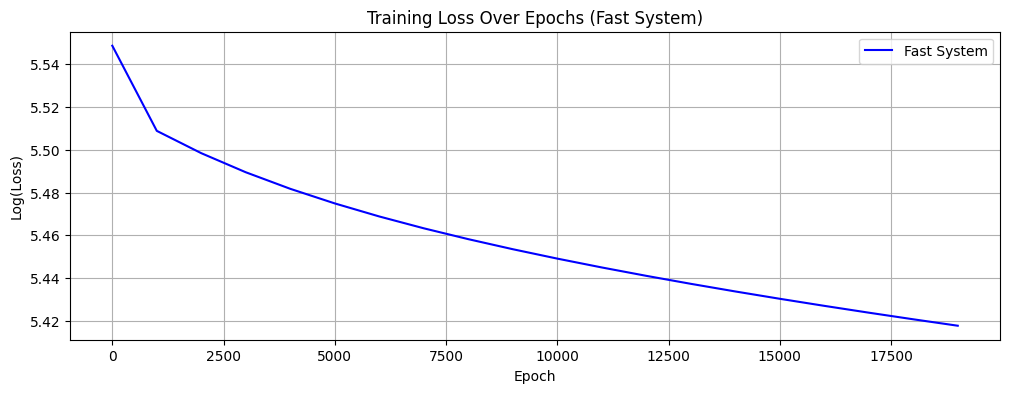

In [5]:
if __name__=='__main__':

    model_slow1  = slow_system_PINN1().to(torch.float64)
    model_fast1  = fast_system_PINN1().to(torch.float64)  
    model_slow2  = slow_system_PINN2().to(torch.float64)  
    model_fast2 = fast_system_PINN2().to(torch.float64) 
    model_slow3  = slow_system_PINN3().to(torch.float64)

    optimizer = torch.optim.Adam(list(model_slow1.parameters()) +\
                                 list(model_fast1.parameters()) +\
                                 list(model_slow2.parameters()) +\
                                 list(model_fast2.parameters()) +\
                                 list(model_slow3.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 20000

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_slow1, model_fast1, model_slow2, model_fast2, model_slow3\
                                    t_tensor, tau_tensor, t2_tensor,\
                                    c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
            phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
            phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
            J1, J2   = j1_pred_slow[-1] , j2_pred_slow[-1]
            #u_0 = u_pred_fast[-1]
            #phi_slow_init = phi_pred_slow[0]
            #phi_slow_end = phi_pred_slow[-1]
            c1_slow_init, c1_slow_end = c1_pred_slow[0], c1_pred_slow[-1]
            c2_slow_init, c2_slow_end = c2_pred_slow[0], c2_pred_slow[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}') 
        loss_values.append(loss_total.item())
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_slow1.eval()
    model_fast1.eval()
    model_slow2.eval()
    model_fast2.eval()
    model_slow3.eval()
    with torch.no_grad():
        # Predictions for fast system
        phi_pred_slow1, u_pred_slow1, c1_pred_slow1, c2_pred_slow1, j1_pred_slow1, j2_pred_slow1, w_pred_slow2 = model_slow2(tau1_tensor).numpy().T
        phi_pred_fast1, u_pred_fast1, c1_pred_fast1, c2_pred_fast1, j1_pred_fast1, j2_pred_fast1, w_pred_fast1 = model_fast1(t1_tensor).numpy().T
        phi_pred_slow2, u_pred_slow2, c1_pred_slow2, c2_pred_slow2, j1_pred_slow2, j2_pred_slow2, w_pred_slow2 = model_slow2(tau2_tensor).numpy().T
        phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
        phi_pred_slow3, u_pred_slow3, c1_pred_slow3, c2_pred_slow3, j1_pred_slow3, j2_pred_slow3, w_pred_slow3 = model_slow3(tau3_tensor).numpy().T
        #phi_slow_init = phi_pred_slow[0]
        #phi_slow_end = phi_pred_slow[-1]
        c1_s_a,l, c2_s_a,l, phi_s_a,l = c1_pred_slow1[-1], c2_pred_slow1[-1], phi_pred_slow1[-1]
        c1_f_a,l, c2_f_a,l, phi_f_a,l = c1_pred_fast1[0], c2_pred_fast1[0], phi_pred_fast1[0]
        c1_s_a,r, c2_s_a,r, phi_s_a,r = c1_pred_slow2[0], c2_pred_slow2[0], phi_pred_slow2[0]
        c1_f_a,r, c2_f_a,r, phi_f_a,r = c1_pred_fast1[-1], c2_pred_fast1[-1], phi_pred_fast1[-1]
        c1_s_b,l, c2_s_b,l, phi_s_b,l = c1_pred_slow2[-1], c2_pred_slow2[-1], phi_pred_slow2[-1]
        c1_f_b,l, c2_f_b,l, phi_f_b,l = c1_pred_fast2[0], c2_pred_fast2[0], phi_pred_fast2[0]
        c1_s_b,r, c2_s_b,r, phi_s_b,r = c1_pred_slow3[0], c2_pred_slow3[0], phi_pred_slow3[0]
        c1_f_b,r, c2_f_b,r, phi_f_b,r = c1_pred_fast2[-1], c2_pred_fast2[-1], phi_pred_fast2[-1]
        J1, J2   = j1_pred_slow[-1] , j2_pred_slow[-1]
    

In [6]:
#print(J1)
#print(J2)
print(j1_pred_fast.shape)
print(j1_pred_fast[0])
print(j1_pred_fast[-1])
print('')

print(j1_pred_slow[0])
print(j1_pred_slow[-1])
print('')

print(j1_pred_fast2[0])
print(j1_pred_fast2[-1])
print('')

(100,)
-0.16795771779110963
-0.1672019980477627

-0.14140765919847076
-0.16953109091154223

-0.17016947677148728
-0.1705351083863833



In [7]:
print(j2_pred_fast.shape)
print(j2_pred_fast[0])
print(j2_pred_fast[-1])
print('')

print(j2_pred_slow[0])
print(j2_pred_slow[-1])
print('')

print(j2_pred_fast2[0])
print(j2_pred_fast2[-1])
print('')

(100,)
0.19833012213769902
0.19905510275632154

0.1731767931031021
0.1967756189231227

0.1961032145238642
0.19571946963419523



In [8]:
print(u_pred_fast.shape)
print(u_pred_fast[0])
print(u_pred_fast[-1])
print('')

print(u_pred_slow[0])
print(u_pred_slow[-1])
print('')

print(u_pred_fast2[0])
print(u_pred_fast2[-1])
print('')

u_length = len(u_pred_slow)
print('u_length=',u_length)
zero_vector = np.zeros(u_length)

(100,)
0.0025939074704581094
0.00018230230534853342

8.797055495172491e-05
4.380937594061947e-05

0.005024034003341969
0.0004763047272542953

u_length= 100


In [9]:
print(phi_pred_fast.shape)
print(phi_pred_fast[0])
print(phi_pred_fast[-1])
print(phi_pred_slow[-1])
print('')


(100,)
-10.06279054417535
-10.00081248475701
-0.010828751381506851



In [10]:
print(z1*c1_pred_fast[0] + z2*c2_pred_fast[0])
print('')
print(z1*c1_pred_fast2[0] + z2*c2_pred_fast2[0])

0.00035890874746069557

-0.00016391574193919123


In [11]:
print(w_pred_fast.shape)
print(np.max(w_pred_fast))
print(w_pred_fast[-1])
print('')

print(w_pred_slow[0])
print(w_pred_slow[-1])
print('')

print(w_pred_fast2[0])
print(w_pred_fast2[-1])
print('')

(100,)
0.002264492782231814
0.0015448796840407675

0.00010330925651458323
0.9998893682091075

1.0014840768131714
0.998514221905461



<ipython-input-12-30c29207f340>:23: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-12-30c29207f340>:24: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-12-30c29207f340>:25: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-12-30c29207f340>:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


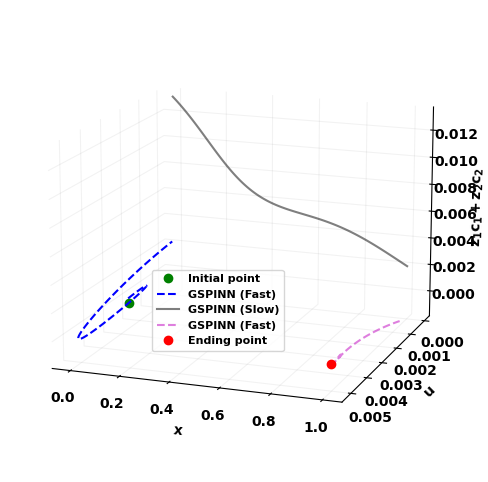

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color of the 3D plot

# Your existing plots
ax.plot(w_init, u_pred_fast[0], z1 * c1_init + z2 * c2_init, 'go', label='Initial point')
ax.plot(w_pred_fast, u_pred_fast, z1 * c1_pred_fast + z2 * c2_pred_fast, 'b--', label='GSPINN (Fast)')
ax.plot(w_pred_slow + w_pred_fast[-1], u_pred_slow + u_0, z1 * c1_pred_slow + z2 * c2_pred_slow + z1 * c1_slow_init + z2 * c2_slow_init, 'k-', label='GSPINN (Slow)', alpha=0.5)
ax.plot(w_pred_fast2, u_pred_fast2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='GSPINN (Fast)', alpha=0.5)
ax.plot(w_end, u_pred_fast2[0], z1 * c1_end + z2 * c2_end, 'ro', label='Ending point')

ax.set_xlabel('$\\mathbf{x}$', fontweight='bold')
ax.set_ylabel('$\\mathbf{u}$', fontweight='bold')
ax.set_zlabel('$\\mathbf{z_1 c_1 + z_2 c_2}$', labelpad=1.9, fontweight='bold')
ax.legend(prop={'weight': 'bold', 'size': 8}, bbox_to_anchor=(0.45, 0.45))
ax.invert_xaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)

# Apply bold font to tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    label.set_fontweight('bold')

# Rotating the figure by 20 degrees
ax.view_init(elev=15, azim=110)

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


In [13]:
r_0 = z1*c1_pred_fast[0] + z2*c2_pred_fast[0] 
r_1 = z1*c1_pred_fast2[0] + z2*c2_pred_fast2[0] # Initial radius
u_0 = u_pred_fast[0]
u_1 = u_pred_fast2[0]
lambda_ = 0.5 # Rate of shrinking
np_co = 10

# Define the range of t
tt = np.linspace(0, np_co * np.pi, 1000000)

# Calculate r as a function of t
r0 = r_0 * np.exp(-lambda_ * tt)
r1 = r_1 * np.exp(-lambda_ * tt)

u0 = u_0 * np.exp(-lambda_ * tt)
u1 = u_1 * np.exp(-lambda_ * tt)

# Create a similar shrinking track with w = 0
w_exact_f = np.zeros_like(tt)
u_exact_f  = u0 * (np.cos(tt) + np.sin(tt))**2  
zc_exact_f = r0 * (np.cos(tt) + np.sin(tt))**3


# Define the line segment from w = 0 to w = 1 at fixed u = 0, z = 0
w_exact_s = np.linspace(0, 1, 1000)
u_exact_s = np.zeros_like(w_exact_s)
zc_exact_s = np.zeros_like(w_exact_s)

w_exact_f2 = np.ones_like(tt)
u_exact_f2 = u1 * (np.cos(tt) + np.sin(tt))**2
zc_exact_f2 = r1 * (np.cos(tt) + np.sin(tt))**3




In [14]:
w_exact_fast  = np.zeros_like(w_pred_fast)
u_exact_fast  = np.zeros_like(u_pred_fast)
zc_exact_fast = np.zeros_like(c1_pred_fast)

for i in range(len(w_pred_fast)):
    # Calculate the distance to all points in w_exact_fast, u_exact_fast and z1c1z2c2_exact_fast
    distances = np.sqrt((w_exact_f - w_pred_fast[i])**2 + (u_exact_f - u_pred_fast[i])**2 +\
                        (zc_exact_f - (z1*c1_pred_fast[i]+z2*c2_pred_fast[i]))**2)
    # Find the index of the minimum distance
    closest_index = np.argmin(distances)
    # Assign the closest exact points to x_fast and y_fast
    w_exact_fast[i] = w_exact_f[closest_index]
    u_exact_fast[i] = u_exact_f[closest_index]
    zc_exact_fast[i] = zc_exact_f[closest_index]

In [15]:
w_exact_slow  = np.zeros_like(w_pred_slow)
u_exact_slow  = np.zeros_like(u_pred_slow)
zc_exact_slow = np.zeros_like(c1_pred_slow)

for i in range(len(w_pred_slow)):
    # Calculate the distance to all points in w_exact_fast, u_exact_fast and z1c1z2c2_exact_fast
    distances2 = np.sqrt((w_exact_s - w_pred_slow[i])**2 + (u_exact_s - u_pred_slow[i])**2 +\
                         (zc_exact_s - (z1*c1_pred_slow[i]+z2*c2_pred_slow[i]))**2)
    # Find the index of the minimum distance
    closest_index2 = np.argmin(distances2)
    # Assign the closest exact points to x_fast and y_fast
    w_exact_slow[i] = w_exact_s[closest_index2]
    u_exact_slow[i] = u_exact_s[closest_index2]
    zc_exact_slow[i] = zc_exact_s[closest_index2]

In [16]:
w_exact_fast2  = np.zeros_like(w_pred_fast2)
u_exact_fast2  = np.zeros_like(u_pred_fast2)
zc_exact_fast2 = np.zeros_like(c1_pred_fast2)

for i in range(len(w_pred_fast2)):
    # Calculate the distance to all points in w_exact_fast, u_exact_fast and z1c1z2c2_exact_fast
    distances3 = np.sqrt((w_exact_f2 - w_pred_fast2[i])**2 + (u_exact_f2 - u_pred_fast2[i])**2 +\
                        (zc_exact_f2 - (z1*c1_pred_fast2[i]+z2*c2_pred_fast2[i]))**2)
    # Find the index of the minimum distance
    closest_index3 = np.argmin(distances3)
    # Assign the closest exact points to x_fast and y_fast
    w_exact_fast2[i] = w_exact_f2[closest_index3]
    u_exact_fast2[i] = u_exact_f2[closest_index3]
    zc_exact_fast2[i] = zc_exact_f2[closest_index3]

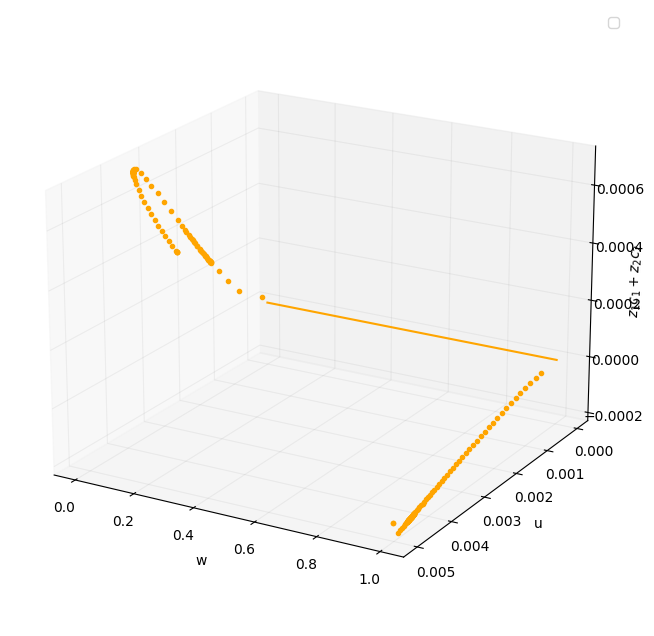

In [17]:

# Create the 3D plot again with the new track
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white') 


# Plot the similar track starting with w = 0
ax.plot(w_exact_fast, u_exact_fast, zc_exact_fast, color='orange', marker='.', linestyle='None')



# Plot the line segment
ax.plot(w_exact_slow, u_exact_slow, zc_exact_slow,  color='orange', linestyle='-')

# Plot the original shrinking track
ax.plot(w_exact_fast2, u_exact_fast2, zc_exact_fast2,  color='orange', marker='.', linestyle='None')

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)


# Set labels and title
ax.set_xlabel('w')
ax.set_ylabel('u')
ax.set_zlabel('$z_1c_1 + z_2c_2$')
ax.zaxis.labelpad = -1
ax.legend()
#ax.invert_xaxis()  
ax.invert_yaxis()
ax.view_init(elev=20)

# Show the plot
plt.show()


In [18]:
# Calculate the error
w_error_fast = np.abs(w_exact_fast - w_pred_fast)
u_error_fast = np.abs(u_exact_fast - u_pred_fast)
zc_error_fast = np.abs(zc_exact_fast - (z1*c1_pred_fast+z2*c2_pred_fast))


w_error_slow = np.abs(w_exact_slow - w_pred_slow)
u_error_slow = np.abs(u_exact_slow - u_pred_slow)
zc_error_slow = np.abs(zc_exact_slow - (z1*c1_pred_slow+z2*c2_pred_slow))


w_error_fast2 = np.abs(w_exact_fast2 - w_pred_fast2)
u_error_fast2 = np.abs(u_exact_fast2 - u_pred_fast2)
zc_error_fast2 = np.abs(zc_exact_fast2 - (z1*c1_pred_fast2+z2*c2_pred_fast2))



# Maximum error
max_w_error_f = np.max(w_error_fast)
max_u_error_f = np.max(u_error_fast)
max_zc_error_f = np.max(zc_error_fast)


print("Maximum errors for the first piece (Fast layer):")
print("Max w error fast:", max_w_error_f)
print("Max u error fast:", max_u_error_f)
print("Max zc error fast:", max_zc_error_f)




# Maximum error for the slow layer
max_w_error_s = np.max(w_error_slow)
max_u_error_s = np.max(u_error_slow)
max_zc_error_s = np.max(zc_error_slow)


print("Maximum errors over the critical manifold:")
print("Max w error slow:", max_w_error_s)
print("Max u error slow:", max_u_error_s)
print("Max zc error slow:", max_zc_error_s)



# Maximum error for the third piece
max_w_error_f2 = np.max(w_error_fast2)
max_u_error_f2 = np.max(u_error_fast2)
max_zc_error_f2 = np.max(zc_error_fast2)


print("Maximum errors for the first piece (Fast layer):")
print("Max w error fast2:", max_w_error_f2)
print("Max u error fast2:", max_u_error_f2)
print("Max zc error fast2:", max_zc_error_f2)

Maximum errors for the first piece (Fast layer):
Max w error fast: 0.002264492782231814
Max u error fast: 0.0014426822628491255
Max zc error fast: 0.002405659042489968
Maximum errors over the critical manifold:
Max w error slow: 0.0004986464007276092
Max u error slow: 0.00012738605951543268
Max zc error slow: 0.006692009063745941
Maximum errors for the first piece (Fast layer):
Max w error fast2: 0.001485778094538981
Max u error fast2: 6.913800980942048e-05
Max zc error fast2: 0.0015751095377828327


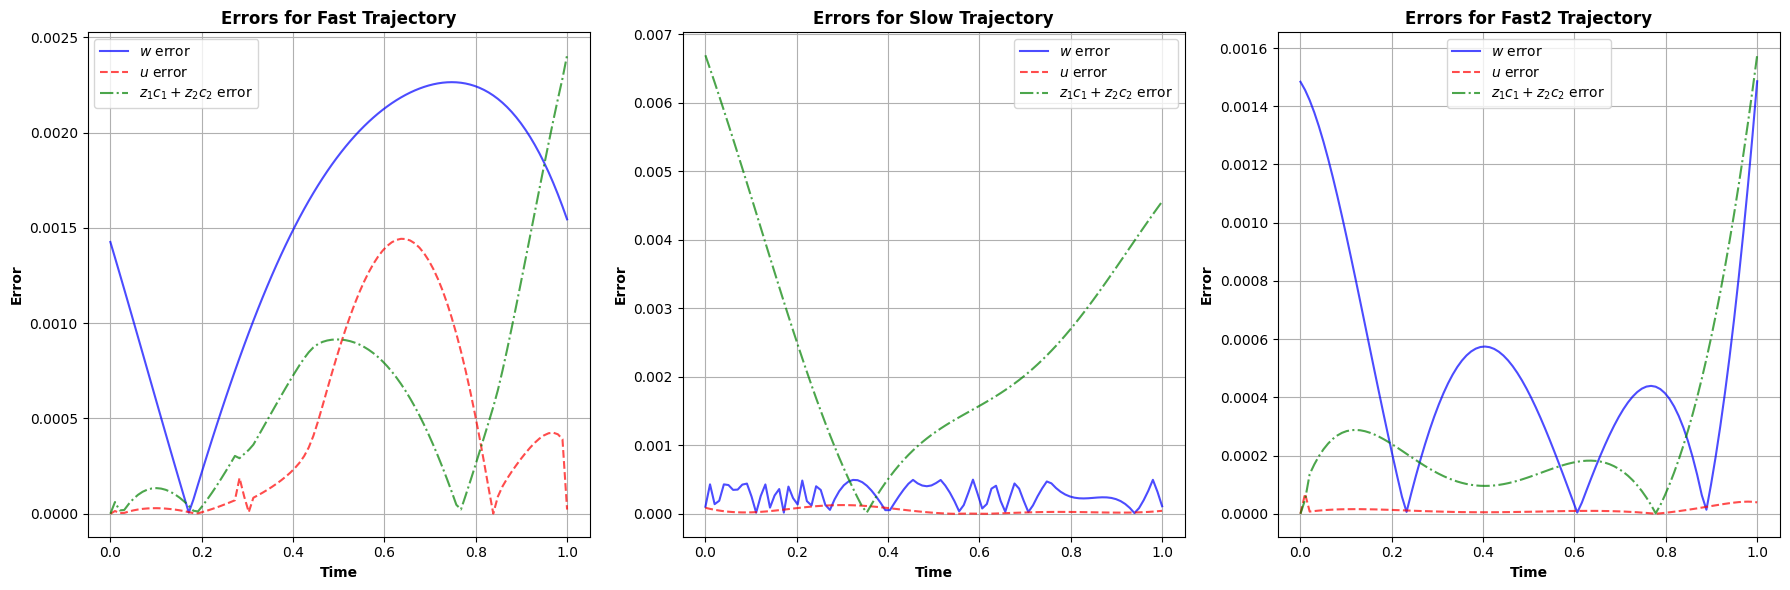

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with actual errors)
tt_end = 1
time = np.linspace(0, tt_end, 100)

# Plot the errors horizontally (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# Plot 1: Fast errors
plt.subplot(1, 3, 1)
plt.plot(time, w_error_fast, label='$w$ error', color='b', linestyle='-', alpha=0.7)
plt.plot(time, u_error_fast, label='$u$ error', color='r', linestyle='--', alpha=0.7)
plt.plot(time, zc_error_fast, label='$z_1c_1+z_2c_2$ error', color='g', linestyle='-.', alpha=0.7)
plt.title('Errors for Fast Trajectory',fontweight='bold')
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Error',fontweight='bold')
plt.legend()
plt.grid()

# Plot 2: Slow errors
plt.subplot(1, 3, 2)
plt.plot(time, w_error_slow, label='$w$ error', color='b', linestyle='-', alpha=0.7)
plt.plot(time, u_error_slow, label='$u$ error', color='r', linestyle='--', alpha=0.7)
plt.plot(time, zc_error_slow, label='$z_1c_1+z_2c_2$ error', color='g', linestyle='-.', alpha=0.7)
plt.title('Errors for Slow Trajectory', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Error', fontweight='bold' )
plt.legend()
plt.grid()

# Plot 3: Fast2 errors
plt.subplot(1, 3, 3)
plt.plot(time, w_error_fast2, label='$w$ error', color='b', linestyle='-', alpha=0.7)
plt.plot(time, u_error_fast2, label='$u$ error', color='r', linestyle='--', alpha=0.7)
plt.plot(time, zc_error_fast2, label='$z_1c_1+z_2c_2$ error', color='g', linestyle='-.', alpha=0.7)
plt.title('Errors for Fast2 Trajectory', fontweight='bold')
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Error',fontweight='bold')
plt.legend()
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

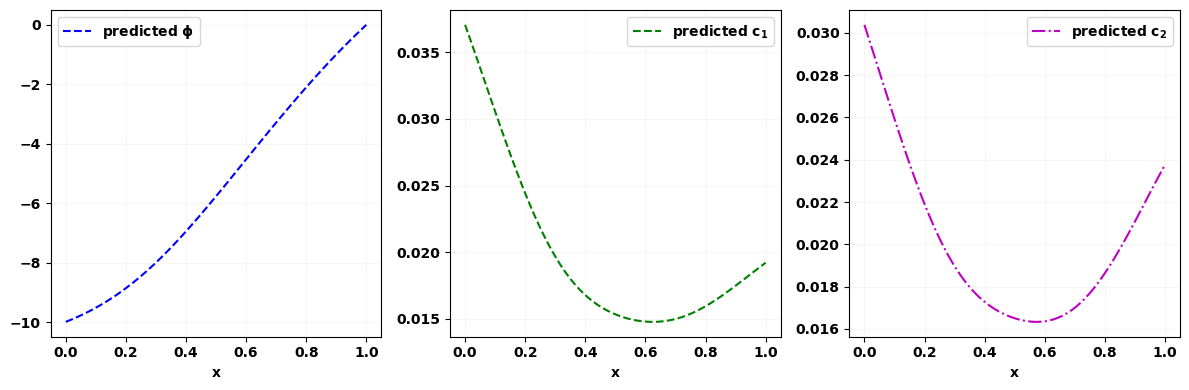

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tau, phi_pred_slow, 'b--', label='predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, c1_pred_slow, 'g--', label='predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(tau, c2_pred_slow, 'm-.', label='predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


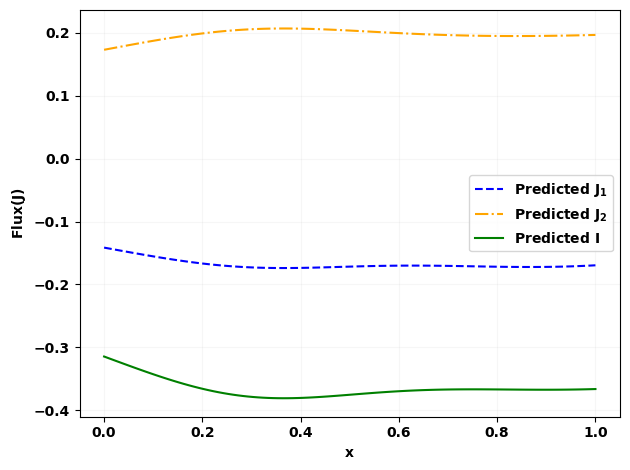

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.4, 4.8))

# Plot the data
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(tau, j2_pred_slow, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(tau, z1*j1_pred_slow + z2*j2_pred_slow, '-', color='green', label='Predicted $\\mathbf{I}$')

# Label the axes
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{Flux (J)}$', fontweight='bold')

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Add grid and legend
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


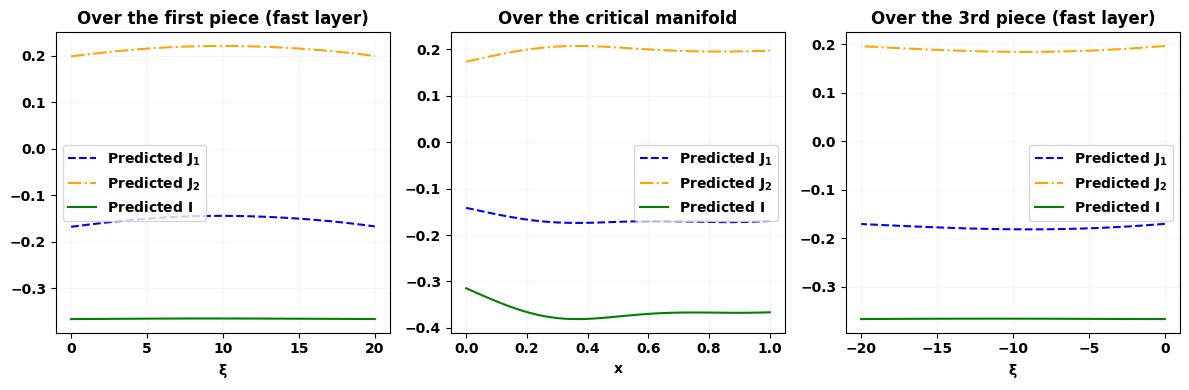

array([0.19833012, 0.19912878])

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(t, j2_pred_fast, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(t, z1*j1_pred_fast + z2*j2_pred_fast, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title('Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(tau, j2_pred_slow, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(tau, z1*j1_pred_slow + z2*j2_pred_slow, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title('Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2 , 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(t2, j2_pred_fast2 , '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(t2, z1*j1_pred_fast2 + z2*j2_pred_fast2, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title('Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()
j2_pred_fast[:2]

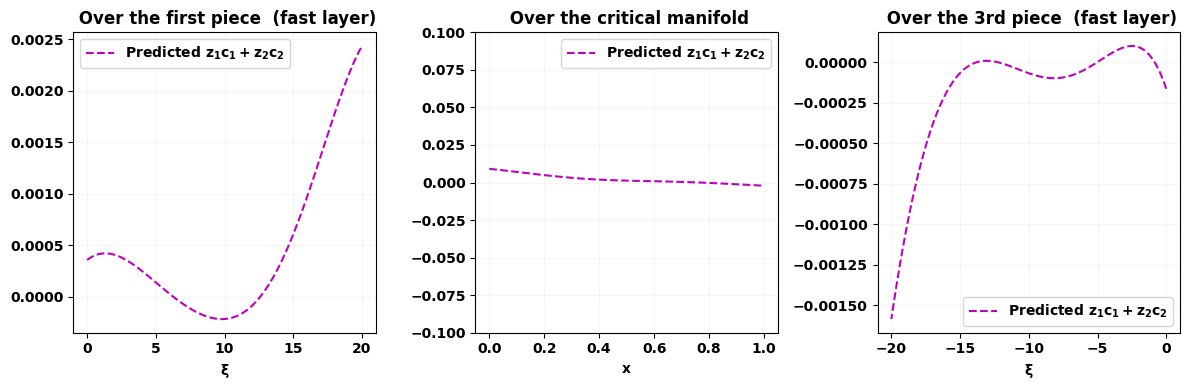

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, z1 * c1_pred_fast + z2 * c2_pred_fast, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece  (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

zc_slow_init = z1 * c1_pred_fast[-1] + z2 * c2_pred_fast[-1]
plt.subplot(1, 3, 2)
plt.plot(tau, z1 * c1_pred_slow + z2 * c2_pred_slow + zc_slow_init, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylim(-0.1, 0.1)
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece  (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


### In the following, we would like to investigate whether the variables are fast or slow based on their dynamic on fast layers and slow layer:

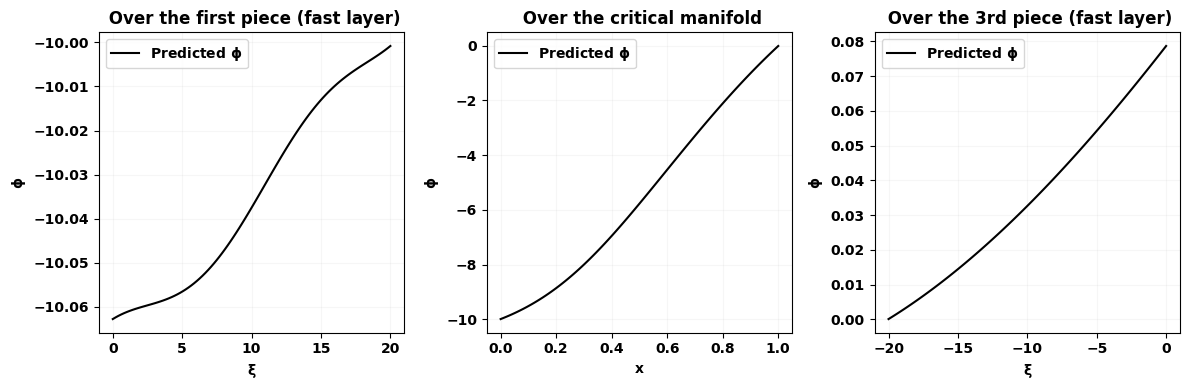

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, phi_pred_fast, 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, phi_pred_slow, 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, phi_pred_fast2 , 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


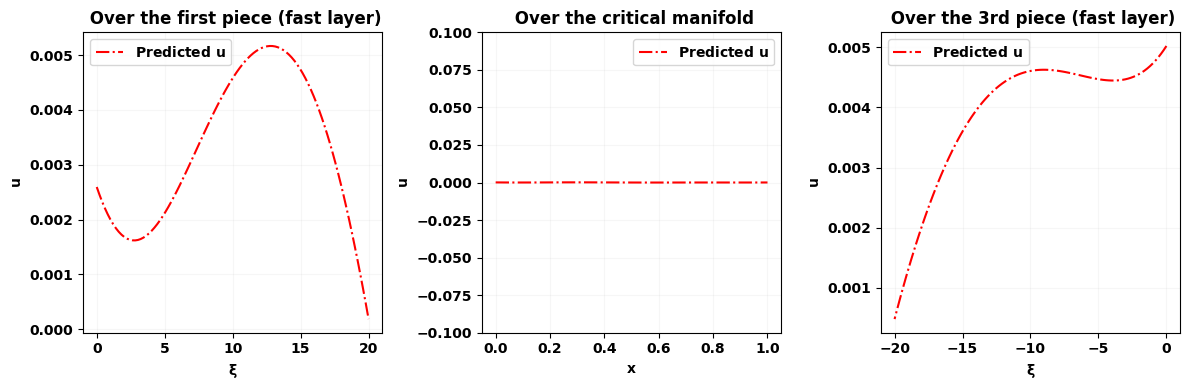

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, u_pred_fast, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, u_pred_slow, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.ylim(-0.1, 0.1)
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, u_pred_fast2, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


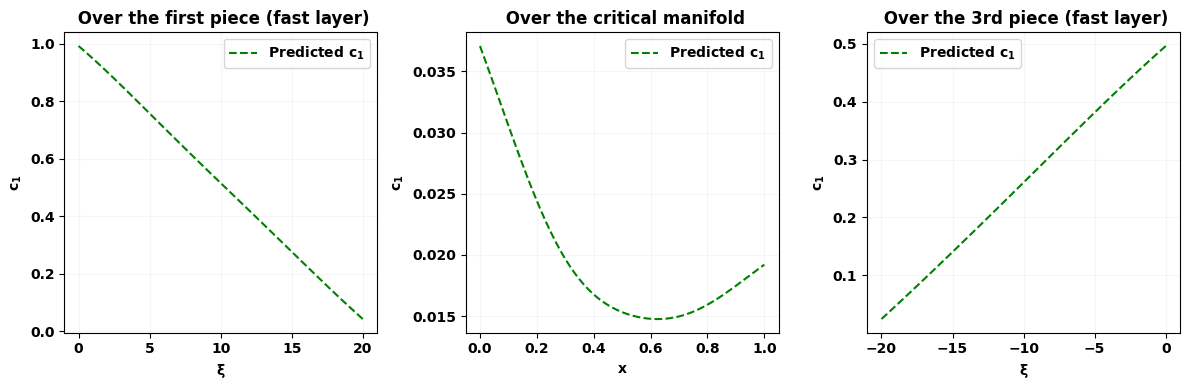

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, c1_pred_fast, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, c1_pred_slow, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, c1_pred_fast2, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


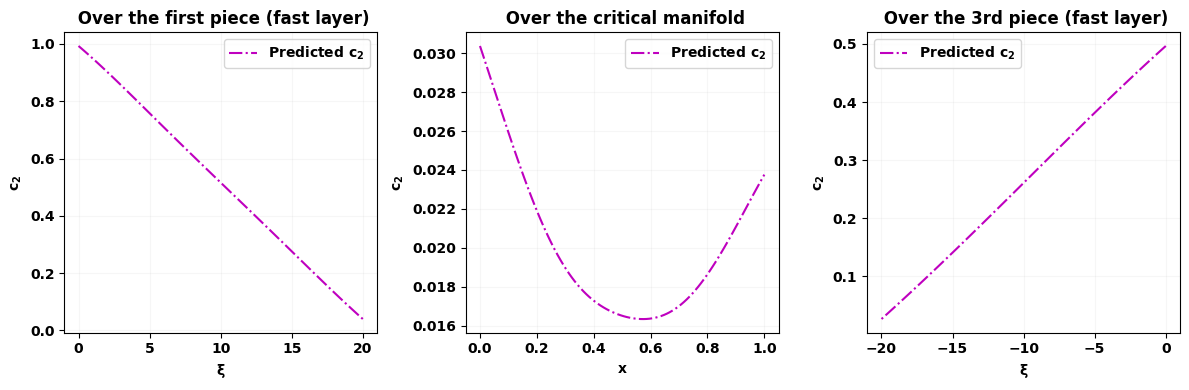

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, c2_pred_fast, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, c2_pred_slow, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, c2_pred_fast2, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


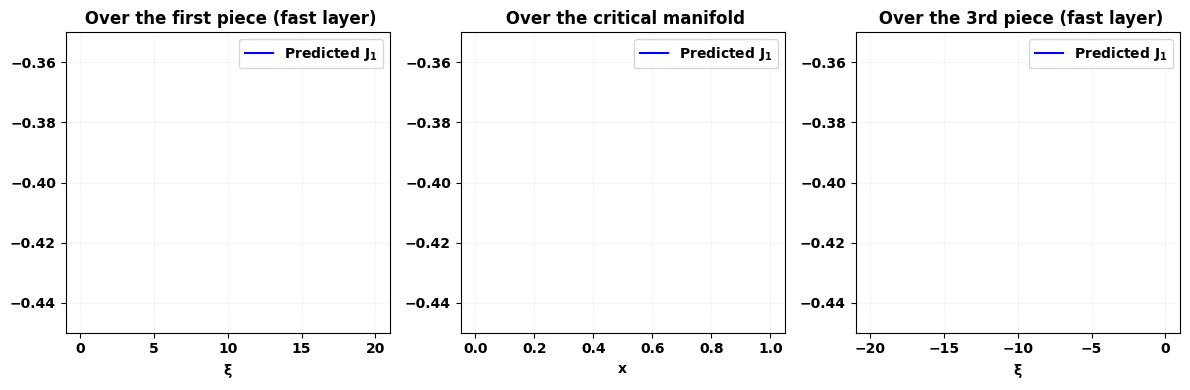

array([-0.16795772, -0.16712947, -0.16630473, -0.16548449, -0.16466976])

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(-0.45, -0.35)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(-0.45, -0.35)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.ylim(-0.45, -0.35)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j1_pred_fast[:5]


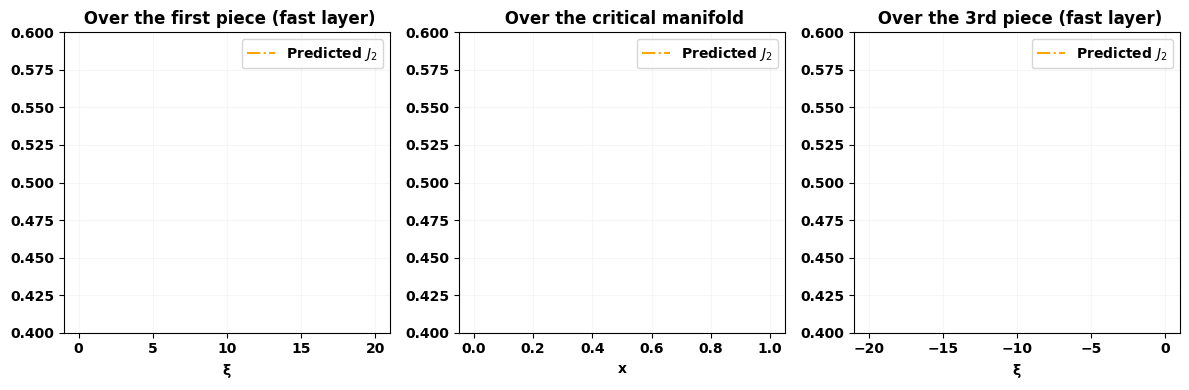

array([0.19610321, 0.19559961, 0.19510349, 0.19461521, 0.1941351 ])

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j2_pred_fast, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(0.4, 0.6)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j2_pred_slow, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(0.4, 0.6)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j2_pred_fast2, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.ylim(0.4, 0.6)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j2_pred_fast2[:5]

<ipython-input-30-6bf06696fa11>:57: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-30-6bf06696fa11>:58: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-30-6bf06696fa11>:59: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


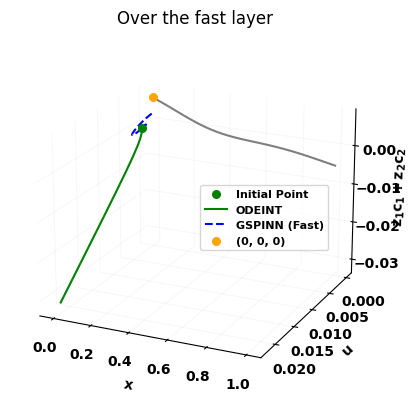

In [30]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


eps =0.01
z1 = 1
z2= -1

def fast_system(y, t, eps):
    u, c1, c2, w = y
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u #- eps * j1
    dc2dt  = -z2 * c2 * u #- eps * j2
    dwdt   = 0 #eps
    
    return [dudt, dc1dt, dc2dt, dwdt]

# Initial conditions
z1= 1
z2 = -1
u0 = u_pred_fast[0]
l1 = c1_init
l2 = c2_init
y0 = [ u0, l1, l2, 0]  # Initial values [u, c1, c2, w]


# Time vector
t_end = 2
t2 = np.linspace(0, t_end, 10)


# Solve the system
solution = odeint(fast_system, y0, t2, args=(eps,))
# Extract results
u, c1, c2, w = solution.T


# Plot the 3D path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(w_init, u0,  z1 * l1 + z2 * l2, color='g', label='Initial Point ', s=30)
ax.plot(w, u, z1 * c1 + z2 * c2, '-',  color='g', label='ODEINT')
ax.plot(w_pred_fast, u_pred_fast, z1 * c1_pred_fast + z2 * c2_pred_fast, 'b--', label='GSPINN (Fast)')
ax.plot(w_pred_slow, u_pred_slow, z1 * c1_pred_slow + z2 * c2_pred_slow, 'k-', alpha=0.5)
ax.scatter(w_pred_fast[-1],u_0, z1 * c1_slow_init + z2 * c2_slow_init, color='orange', label='(0, 0, 0)', s=30)


ax.set_xlabel('$\\mathbf{x}$', fontweight='bold')
ax.set_ylabel('$\\mathbf{u}$', fontweight='bold')
ax.set_zlabel('$\\mathbf{z_1 c_1 + z_2 c_2}$', labelpad=1, fontweight='bold')
ax.invert_xaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.03, 0.03, 0.03, 0.03)) 
ax.yaxis._axinfo['grid'].update(color=(0.03, 0.03, 0.03, 0.03))
ax.zaxis._axinfo['grid'].update(color=(0.03, 0.03, 0.03, 0.03))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)

# Apply bold font to tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    label.set_fontweight('bold')

# Labels and legend
ax.legend(prop={'weight': 'bold', 'size': 8}, bbox_to_anchor=(0.5, 0.6))
ax.set_title('Over the fast layer')
ax.view_init(elev=20, azim=115)

plt.grid(True, alpha=0.1)
plt.show()


<ipython-input-31-0a658dd6232f>:66: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-31-0a658dd6232f>:67: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-31-0a658dd6232f>:68: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


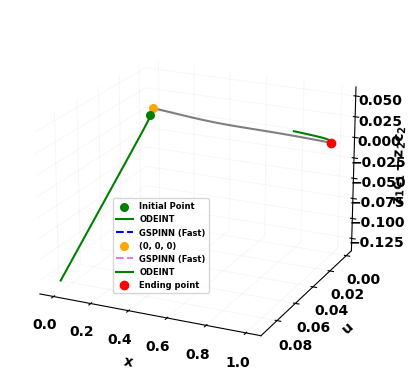

In [31]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


eps =0.01
z1 = 1
z2= -1

def fast_system(y, t, eps):
    u, c1, c2, w = y
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u #- eps * j1
    dc2dt  = -z2 * c2 * u #- eps * j2
    dwdt   = 0 #eps
    
    return [dudt, dc1dt, dc2dt, dwdt]

# Initial conditions
z1= 1
z2 = -1
u0 = u_pred_fast[0]
u1 = u_pred_fast2[0]
l1 = c1_init
l2 = c2_init
r1 = c1_pred_fast2[0]
r2 = c2_pred_fast2[0]
y0 = [ u0, l1, l2, 0]  # Initial values [u, c1, c2, w]
y1 = [ u1, r1, r2, 1] 

# Time vector
t_end = 3
t_end_2 = 3
t2 = np.linspace(0, t_end, 10)
t2_2 = np.linspace(0, -t_end_2, 10)

# Solve the system
solution = odeint(fast_system, y0, t2, args=(eps,))
solution2 = odeint(fast_system, y1, t2_2, args=(eps,))
# Extract results
u, c1, c2, w = solution.T
u_2, c1_2, c2_2, w_2 = solution2.T

# Plot the 3D path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(w_init, u0,  z1 * l1 + z2 * l2, color='g', label='Initial Point ', s=30)
ax.plot(w, u, z1 * c1 + z2 * c2, '-',  color='g', label='ODEINT')
#ax.plot(w_init, u_pred_fast[0], z1 * c1_init + z2 * c2_init, 'go', label='Initial point')
ax.plot(w_pred_fast, u_pred_fast, z1 * c1_pred_fast + z2 * c2_pred_fast, 'b--', label='GSPINN (Fast)')
ax.plot(w_pred_slow, u_pred_slow, z1 * c1_pred_slow + z2 * c2_pred_slow, 'k-', alpha=0.5)
ax.scatter(w_pred_fast[-1],u_0, z1 * c1_slow_init + z2 * c2_slow_init, color='orange', label='(0, 0, 0)', s=30)
ax.plot(w_pred_fast2, u_pred_fast2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='GSPINN (Fast)', alpha=0.5)
ax.plot(w_2, u_2, z1 * c1_2 + z2 * c2_2, '-',  color='g', label='ODEINT')
ax.plot(w_end, u_pred_fast2[0], z1 * c1_end + z2 * c2_end, 'ro', label='Ending point')


ax.set_xlabel('$\\mathbf{x}$', fontweight='bold')
ax.set_ylabel('$\\mathbf{u}$', fontweight='bold')
ax.set_zlabel('$\\mathbf{z_1 c_1 + z_2 c_2}$', labelpad=1, fontweight='bold')
ax.invert_xaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.03, 0.03, 0.03, 0.03)) 
ax.yaxis._axinfo['grid'].update(color=(0.03, 0.03, 0.03, 0.03))
ax.zaxis._axinfo['grid'].update(color=(0.03, 0.03, 0.03, 0.03))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)

# Apply bold font to tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    label.set_fontweight('bold')

# Labels and legend
ax.legend(prop={'weight': 'bold', 'size': 6}, bbox_to_anchor=(0.55, 0.5))
ax.view_init(elev=20, azim=115)

plt.grid(True, alpha=0.1)
plt.show()
